In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.rcParams.update({'font.size': 12})
import matplotlib.colors as mcolors
colors = list( mcolors.TABLEAU_COLORS )

In [2]:
from glob import glob
import os
import peakfit as pf

In [12]:
def read_sin2psi(csv_file):
    """
    
    using the one-file export option
    leads to a data array with all different psi and phi measures
    reshape date to have a 3D array of shape: (2theta, psi, phi)
    """
    # Try to get the number of header line:
    with open(csv_file, 'r') as f:
        for k in range(40):
            line = f.readline()
            if line.startswith('[Scan points]'):
                header = f.readline()
                break
    
    # import data
    data = np.genfromtxt(csv_file, delimiter=',', skip_header=k+2)

    twoth = np.unique( data[:, 0] )
    psi = np.unique( data[:, 1] )
    phi = np.unique( data[:, 2] )

    intensities_flat = data[:, -1]

    intensities = intensities_flat.reshape(-1,
                                           len(psi),
                                           len(phi),
                                           order='F')
    # ‘F’ Fortran-like index order, with the first index changing fastest
    
    return twoth, psi, phi, intensities

In [32]:
def distance_from_Bragg(deux_theta, lmbda = 1.5405929):
    # Ang., x-ray wavelength   K_alpha1 Cu
    deux_theta = np.asarray(deux_theta)
    return lmbda/2/np.sin(deux_theta/2 *np.pi/180)


def fit_all(twoth_span, psi_span, phi_span, intensities,
            graph=False, output_keys=['x0', 'x0_std', 'fwhm']):
    
    fit_results = {key: np.NaN*np.ones(intensities.shape[1:]) for key in output_keys}
    for phi_idx in range(len(phi_span)):
        if graph: plt.figure()
        
        for k, psi_k in enumerate( psi_span ):
            y = intensities[:, k, phi_idx]
            
            # Graph
            if graph:
                color = colors[k % len(colors)]
                plt.plot(twoth_span, y, '.', label=psi_k, 
                          alpha=0.5, color=color)
                
            try:
                
                results, fit = pf.peakfit(twoth_span, y,
                                       pf.PseudoVoigt())

                for key, array in fit_results.items():
                    array[k, phi_idx] = results[0][key]
                    
                    if graph:
                        plt.plot(twoth_span, fit(twoth_span), color=color)

            except RuntimeError:
                print(f'fit error for {phi_idx}, {psi_k}')

        if graph:
            plt.text(twoth_span.min(),
                     0.9*intensities[:, :, phi_idx].max(),
                     f'phi={phi_span[phi_idx]} deg')
            #plt.title(measure_list[0]);
            plt.xlabel('two theta (deg)');

    return fit_results

In [14]:
# List data files:
data_dir = 'data'
measure_list = glob(os.path.join(data_dir, '*.csv'))
print(', '.join(measure_list))

data/sin2psi_ARB_Nb321.csv, data/sin2psi_ARB_Nb112.csv, data/sin2psi_ARB_Cu111.csv, data/sin2psi_ARB_Cu200.csv


In [15]:
#for k, psi in enumerate( psi_span ):
#    plt.plot(two_th_span, intensities[:, k, 0], label=psi )
#plt.legend()
#plt.title(measure_list[0]);
#plt.xlabel('two theta (deg)');

d0 = {Cu:3.615 Å, Nb:3.3063 Å}

$$
\varepsilon_{\psi} = \varepsilon_{⟂} + (\varepsilon_{⫽}-\varepsilon_{⟂})\sin^2 \psi
$$

In [16]:
d0_mat = {'Cu':3.615, 'Nb':3.3063}

In [39]:
i = 0  # used to selec the filename

file: data/sin2psi_ARB_Nb321.csv
a0 (A): 3.3063
hkl: [3. 2. 1.]
d0 (A): 0.8836458441350487
phi=  0° --> eps_N≃-0.106331% eps_T≃-0.124456%
phi= 90° --> eps_N≃-0.081094% eps_T≃-0.330809%
phi=180° --> eps_N≃-0.094903% eps_T≃-0.174293%
phi=270° --> eps_N≃-0.085664% eps_T≃-0.291389%
output/sin2psi_ARB_Nb321.svg saved


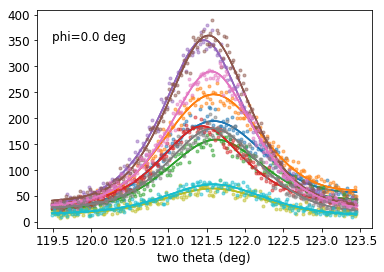

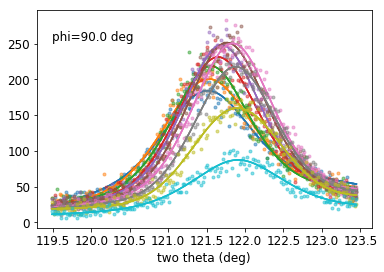

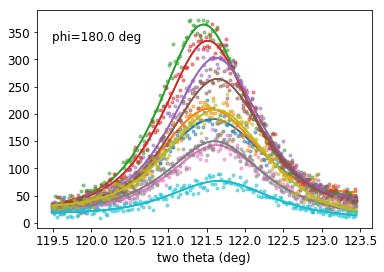

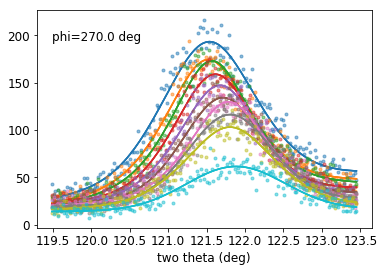

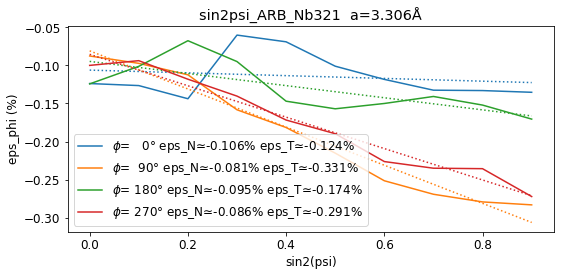

In [40]:
# ========== 
#  sin2 psi
# ==========

filename = measure_list[i]
print('file:', filename)

image_name = os.path.basename(filename)
measure_name = image_name.replace('csv', '').strip('.')

a0 = [a for n, a in d0_mat.items() if n in filename][0]
print('a0 (A):', a0)
hkl = np.array( [float(u) for u in measure_name[-3:]] )
d0 = a0/np.sqrt(np.sum(hkl**2))

print('hkl:', hkl)
print('d0 (A):', d0)
twoth_span, psi_span, phi_span, I = file_path = read_sin2psi(filename)

fit_results = fit_all(twoth_span, psi_span, phi_span, I, graph=True)



plt.figure(figsize=(8, 4));
k = 0
d_hlk = distance_from_Bragg(fit_results['x0'])
sin2psi = np.sin(psi_span *np.pi/180)**2
for phi, d_hlk_phi in zip(phi_span, d_hlk.T):
    
    # linear fit:
    
    eps_phi = (d_hlk_phi - d0)/d0
    mask = np.logical_not(np.isnan(eps_phi))
    slope, intercept = np.polyfit(sin2psi[mask], 100*eps_phi[mask], 1)
    
    eps_normal = intercept
    eps_plan = slope + intercept

    print(f'phi={phi:3.0f}°', '-->',f'eps_N≃{eps_normal:.6f}%', f'eps_T≃{eps_plan:.6f}%')
    
    # graph
    color = colors[k % len(colors)]
    k += 1
    plt.plot(sin2psi, 100*eps_phi, '-', 
             label=f'$\phi$={phi:4.0f}° eps_N≃{eps_normal:.3f}% eps_T≃{eps_plan:.3f}%',
             color=color);
    plt.plot(sin2psi, (slope*sin2psi + intercept), 'k:', color=color)
    
    
plt.legend()
plt.title(measure_name + f'  a={a0:.3f}Å');
plt.xlabel('sin2(psi)'); plt.ylabel('eps_phi (%)');
plt.tight_layout();
outputdir = 'output'

image_name = image_name.replace('csv', 'svg')
image_path = os.path.join(outputdir, image_name)
plt.savefig(image_path)
print(f'{image_path} saved')

i += 1